# DEMO

In [1]:
import librosa
import numpy as np
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore') # ignoring runtime warning if needed


C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Config

In [2]:
SEED = 42
batch_size = 32
epochs = 1000
learning_rate = 0.003

# Data extraction (From kaggle := need to rewrite `def extract_features(file)`)

In [3]:
def extract_features(file):
    y, sr = librosa.load(file)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    # Chroma_stft
    stft = np.abs(librosa.stft(y=y))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result.reshape(1, 9, 18) # Reshape as CNN input: 1 channel 9x18 matrix

In [4]:
# My DatasetLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data)  
        self.labels = torch.tensor(labels) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


### Generate datasets  

In [5]:
# Training data structures
# 
# data\
#     CremaV3\
#         HAP\
#             xxxx.waw
#             xxxx.waw
#             xxxx.waw
#         NEU\
#             xxxx.waw
#             xxxx.waw
#             xxxx.waw
#         SAD\
#             xxxx.waw
#             xxxx.waw
#             xxxx.waw
# 


In [6]:
# preprocessing, labeling the .wav file base on folder name
Audio_folder = './data/CremaV3/'
feature_tensors = []
label_tensors = []

emo_dict = {'HAP': 0, 'NEU': 1, 'SAD': 2} # Label encoding

for emotion_folder in os.listdir(Audio_folder):
    subfolder = os.path.join(Audio_folder, emotion_folder)
    if os.path.isdir(subfolder):  
        print(f"Processing emotion: {emotion_folder}")
        for audio_file in os.listdir(subfolder):
            if audio_file.endswith(".wav"): 
                file_path = os.path.join(subfolder, audio_file)
                features = extract_features(file_path)
                feature_tensors.append(features)
                label_tensors.append(emo_dict[emotion_folder])

Processing emotion: HAP
Processing emotion: NEU
Processing emotion: SAD


# Model

In [8]:
# Our CNN model
class CNN(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        
        self.dropout = torch.nn.Dropout(0.3)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(512, 256) 
        self.fc2 = torch.nn.Linear(256, 64) 
        self.fc3 = torch.nn.Linear(64, num_classes)    
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


# Training process

In [9]:
# spliting Trainig : Val : Testing -> 80% : 10% : 10%
dataset = CustomDataset(feature_tensors, label_tensors)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# AUC metric
def evaluate(mymodel, dataloader):
    mymodel.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.float(), labels.long()
            outputs = mymodel(inputs)
            _, predict = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
    return correct / total

In [11]:
model = CNN(num_classes=3)  
random.seed(SEED)
# history
history = {'trainLoss' : [],
           'trainAUC' : [],
           'valAUC' : []}

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iterations = tqdm(range(epochs))
# Loop
for epoch in iterations:
    losses = []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.float(), batch_y.long()  
        optimizer.zero_grad()  
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    history['trainLoss'].append(np.mean(losses))
    history['trainAUC'].append(evaluate(model, train_loader))
    history['valAUC'].append(evaluate(model, val_loader))
    
    iterations.set_postfix({"Loss": f"{history['trainLoss'][-1]:.4f}", "trainAUC": f"{history['trainAUC'][-1]:.4f}", "valAUC": f"{history['valAUC'][-1]:.4f}"}, refresh=True)




100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s, Loss=0.3897, trainAUC=0.8439, valAUC=0.6878]


# Results

In [12]:
def smoothing(data, window_size):
    avg = []
    count = 0
    for i, value in enumerate(data, 1):
        count += value
        if i >= window_size:
            avg.append(count / window_size)
            count -= data[i - window_size]
    return avg


In [28]:
def result_generation(history, smooth):    
    loss = smoothing(history['trainLoss'], smooth)
    trian_auc = smoothing(history['trainAUC'], smooth)
    val_auc = smoothing(history['valAUC'], smooth)
    epochs = range(1, len(loss) + 1)

    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    ax1.set_ylabel('Loss', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax1.set_xlabel('epochs', fontsize=15)
    L1, = ax2.plot(epochs, trian_auc, 'blue', label='Training Accuracy')
    L2, = ax1.plot(epochs, loss, 'red', label='Training Loss')
    L3, = ax2.plot(epochs, val_auc, 'green', label='Val Accuracy')
    plt.legend(handles = [L1, L2, L3], loc = 'upper left', fontsize=10)
    plt.title(f'CNN Training process (smoothing {smooth})')
    plt.savefig('./results/CNN.png')

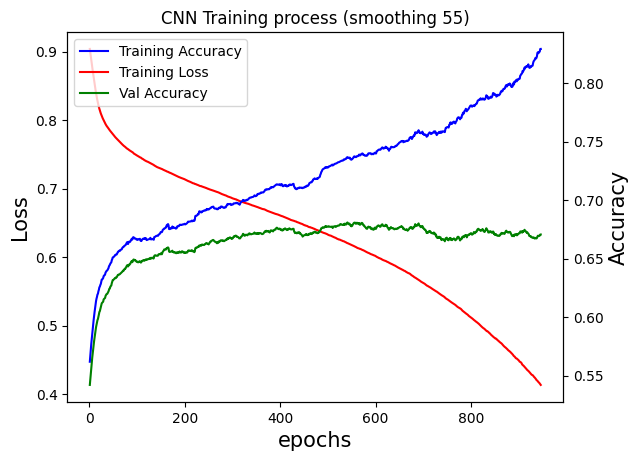

In [29]:
result_generation(history, 55)

# Evaluation

### test data

In [15]:
print(f'Accuracy on test set: {evaluate(model, test_loader):.4f}')

Accuracy on test set: 0.6593


# Save

In [16]:
torch.save(model.state_dict(), './CNNModel.pth')

# Load

In [24]:
model = CNN(num_classes=3) 
model.load_state_dict(torch.load('./CNNModel.pth'))

<All keys matched successfully>

In [26]:
print(f'Accuracy on test set: {evaluate(model, test_loader):.4f}')

Accuracy on test set: 0.6593
